# Data Processing

The problems we have to deal with are:
1. The features have have high multicollinearity. 
2. There are outliers present in the data.

## Load the libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read the data

In [3]:
df =pd.read_csv("E:\IIT Chicago\Sem 3\Data Preparation and Analysis - CSP 571\Project\Final Submission\data_public.csv")

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\Siddhant\AppData\Local\Temp\ipykernel_22884\460623077.py:1: SyntaxWarning: invalid escape sequence '\I'
  df =pd.read_csv("E:\IIT Chicago\Sem 3\Data Preparation and Analysis - CSP 571\Project\Final Submission\data_public.csv")


## Handling Multicollinearity

I will iteratively calculate the Variance Inflation Factor (VIF) for each feature and sequentially remove the feature with the highest VIF score. 

To ensure that only highly correlated features are removed, I have set a high VIF threshold of 100. 

This approach allows me to focus on eliminating features with significant multicollinearity, while retaining the ones that may contribute meaningfully to the model. 

Afterwards, I will select a model capable of effectively handling any remaining collinearity.

In [4]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    """Calculate the VIF for each feature in the dataframe."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def drop_max_vif_feature(dataframe, threshold):
    """Drop features with high VIF values recursively until all features have a VIF below the threshold."""
    while True:
        # Calculate VIF for each feature
        vif_data = calculate_vif(dataframe)
        
        # Find the feature with the highest VIF
        max_vif = vif_data["VIF"].max()
        
        # If the maximum VIF is below the threshold, break the loop
        if max_vif < threshold:
            break
        
        # Find the feature with the highest VIF
        feature_to_drop = vif_data.loc[vif_data["VIF"] == max_vif, "Feature"].values[0]
        
        # Drop the feature with the highest VIF
        dataframe = dataframe.drop(columns=[feature_to_drop])
        
        # Print the dropped feature
        print(f"Dropped feature: {feature_to_drop} with VIF: {max_vif}")
        
    # Final VIF after dropping features
    final_vif = calculate_vif(dataframe)
    print("\nFinal VIFs for remaining features:")
    print(final_vif)

    return dataframe, final_vif

# Create a copy of the dataset
df_copy = df.copy()

# Replace NaN and infinite values in the copy
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
df_copy = df_copy.fillna(df_copy.mean())  # Replace NaN values with column mean

# Define VIF threshold
threshold = 100.0  # Adjust this value based on your tolerance for multicollinearity

# Perform VIF analysis and drop columns with high VIF
df_cleaned, final_vif = drop_max_vif_feature(df_copy, threshold)

# Print final decision
print("\nColumns to keep after VIF analysis:")
print(df_cleaned.columns.tolist())


Dropped feature: A with VIF: 511.3310628307371
Dropped feature: C with VIF: 361.1652960523005
Dropped feature: H with VIF: 347.6858611766211
Dropped feature: O with VIF: 310.3736175883786
Dropped feature: E with VIF: 263.90938512412663
Dropped feature: K with VIF: 220.87898493627557
Dropped feature: N with VIF: 137.90707651937677
Dropped feature: J with VIF: 111.17621009486326

Final VIFs for remaining features:
  Feature        VIF
0       B  26.552840
1       D  54.882628
2       F  80.153084
3       G  79.671101
4       I  82.518320
5       L  12.881965
6       M  27.580294
7   Class  11.601515

Columns to keep after VIF analysis:
['B', 'D', 'F', 'G', 'I', 'L', 'M', 'Class']


### Obesrvation:
Total of 8 features were dropped in this step.

In [4]:
# List of columns to keep
columns_to_keep = ['B', 'D', 'F', 'I', 'J', 'L', 'M', 'Class']

# Retain only the specified columns in the dataset
df = df[columns_to_keep]

# Display the cleaned dataset
print("Dataset after retaining selected columns:")
print(df.head())

Dataset after retaining selected columns:
           B          D          F          I           J         L  \
0 -12.210984 -15.611916  76.904999  82.873279  127.350084 -5.992983   
1 -14.195695  22.293822 -18.373955  -8.356041   23.792402  2.809159   
2 -20.418850  19.790280 -19.189004  -6.612401   26.285392  6.191587   
3  -5.785352  -9.900781  85.122288  82.560019  157.105143 -3.621070   
4 -12.447710 -13.277704  91.101870  89.961688  130.299732 -1.573922   

           M  Class  
0 -14.689648      3  
1 -59.330681      2  
2 -56.924996      2  
3 -15.469156      3  
4 -15.128603      3  


## Outlier Processing

First, let's again see the outliers.

In [ ]:
classes = df['Class']
features = df.drop('Class', axis=1)

# Function to calculate IQR and bounds for each feature, separately by class
def calculate_iqr_for_class(class_data):
    Q1 = class_data.quantile(0.25)
    Q3 = class_data.quantile(0.75)
    IQR = Q3 - Q1
    upper_bounds = Q3 + 1.5 * IQR
    lower_bounds = Q1 - 1.5 * IQR
    return lower_bounds, upper_bounds

# Function to calculate outliers for each class and feature
def count_outliers_by_class(class_label, feature_name, lower_bounds, upper_bounds):
    class_data = df[df['Class'] == class_label][feature_name]
    outliers = (class_data > upper_bounds[feature_name]) | (class_data < lower_bounds[feature_name])
    return outliers.sum()

# Function to calculate rows with at least one outlier for each class
def count_rows_with_at_least_one_outlier(class_label, lower_bounds, upper_bounds):
    class_data = df[df['Class'] == class_label][features.columns]
    outliers = (class_data > upper_bounds) | (class_data < lower_bounds)
    rows_with_outliers = outliers.any(axis=1).sum()  # Count rows with at least one outlier
    return rows_with_outliers

# Function to identify outliers for each feature based on class-specific bounds
def identify_outliers_by_class(class_label, lower_bounds, upper_bounds):
    class_data = df[df['Class'] == class_label][features.columns]
    outliers = (class_data > upper_bounds) | (class_data < lower_bounds)
    return outliers

# Function to calculate rows with at least one outlier across the entire dataset
def count_total_rows_with_at_least_one_outlier():
    # Initialize a DataFrame to track outliers across all classes
    outlier_mask = pd.DataFrame(False, index=df.index, columns=features.columns)
    
    # Iterate over each class and check for outliers
    for class_label in df['Class'].unique():
        lower_bounds, upper_bounds = calculate_iqr_for_class(df[df['Class'] == class_label][features.columns])
        outliers = identify_outliers_by_class(class_label, lower_bounds, upper_bounds)
        outlier_mask = outlier_mask | outliers  # Combine outliers across all classes
    
    # Count rows with at least one outlier (True) in any feature
    rows_with_outliers = outlier_mask.any(axis=1).sum()
    return rows_with_outliers

# Dictionary to store the result
outliers_by_class_feature = {}
rows_with_at_least_one_outlier = {}
total_outliers_per_class = {}

# Iterate through each class and feature to calculate outliers and rows with outliers
for class_label in df['Class'].unique():
    # Calculate IQR bounds for the current class
    lower_bounds, upper_bounds = calculate_iqr_for_class(df[df['Class'] == class_label][features.columns])

    # Initialize the dictionary for current class outliers
    outliers_by_class_feature[class_label] = {}

    # Calculate outliers by feature for the current class
    for feature_name in features.columns:
        count = count_outliers_by_class(class_label, feature_name, lower_bounds, upper_bounds)
        outliers_by_class_feature[class_label][feature_name] = count
    
    # Count rows with at least one outlier for the current class
    rows_with_at_least_one_outlier[class_label] = count_rows_with_at_least_one_outlier(class_label, lower_bounds, upper_bounds)
    
    # Calculate total number of outliers for the current class
    total_outliers = sum(outliers_by_class_feature[class_label].values())
    total_outliers_per_class[class_label] = total_outliers

# Convert the result to DataFrame for readability
outliers_df = pd.DataFrame(outliers_by_class_feature).T
rows_with_outliers_df = pd.DataFrame.from_dict(rows_with_at_least_one_outlier, orient='index', columns=['Rows with At Least One Outlier'])
total_outliers_df = pd.DataFrame.from_dict(total_outliers_per_class, orient='index', columns=['Total Outliers'])

# Merge all results into a single DataFrame
final_df = outliers_df.join([rows_with_outliers_df, total_outliers_df])

# Reorder the classes and transpose the DataFrame
final_df = final_df.sort_index().T

# Print the final result for outliers by class and feature
print("Outliers by Class and Feature:")
print(final_df)

# Calculate and print the total number of rows with at least one outlier across the entire dataset
total_rows_with_outliers = count_total_rows_with_at_least_one_outlier()
print(f"\nTotal rows with at least one outlier across the dataset: {total_rows_with_outliers}")

Outliers by Class and Feature:
                                1      2       3
B                               0   3308   99636
D                               0   3198   99570
F                               0   3103       0
I                               0   3052       0
J                               0   3152       0
L                               0   3192   96609
M                               0   3085       0
Rows with At Least One Outlier  0  21636   99706
Total Outliers                  0  22090  295815

Total rows with at least one outlier across the dataset: 121342


### Key point:
As different classes have different distribution of the outliers across features we are going to treat with each class differently.

### Class 1:

Class 1 has no outlier so we are going to leave it as it is.

### Class 2:

First, let's see the distribution of outliers for class = 2.

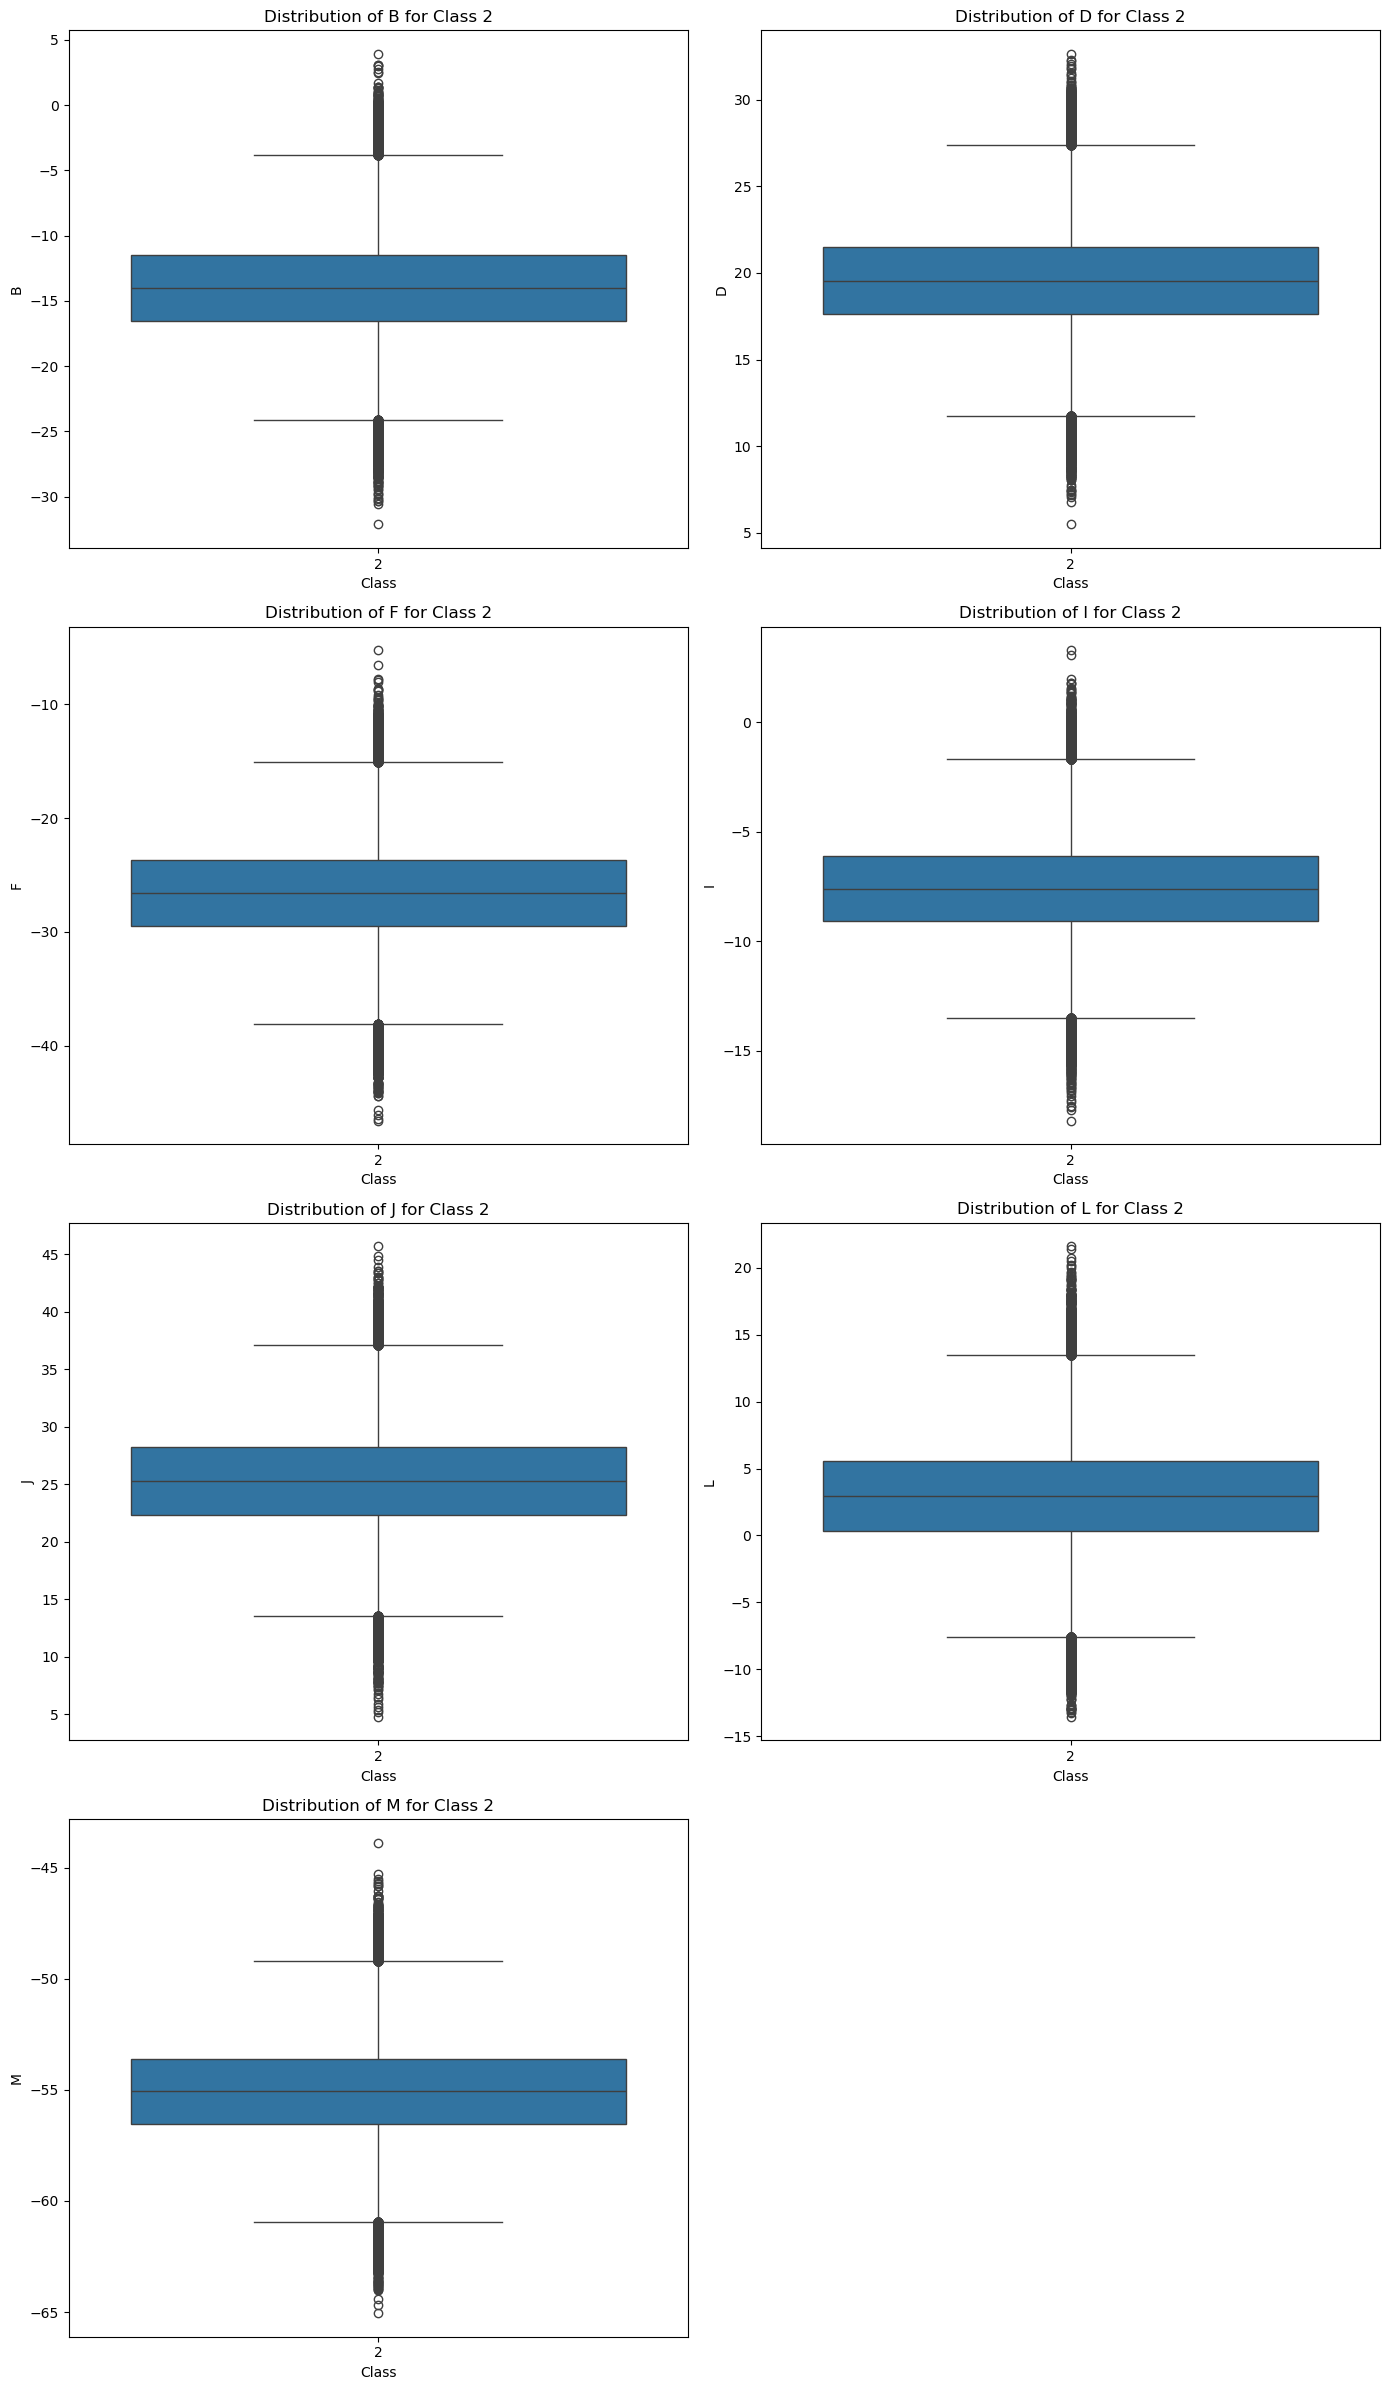

In [9]:
# Filter the dataset for Class 2
class_2_data = df[df['Class'] == 2]

# Number of features to plot (excluding 'Class')
num_features = len(df.drop(columns=['Class']).columns)

# Calculate number of columns and rows for subplots
ncols = 2  # Number of columns you want
nrows = int(np.ceil(num_features / ncols))  # Calculate rows based on the number of features

# Create subplots with the calculated number of rows and columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a subplot
for i, feature in enumerate(df.drop(columns=['Class']).columns):
    sns.boxplot(x='Class', y=feature, data=class_2_data, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature} for Class 2")

# Remove any extra empty subplots if there are more subplots than features
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

### Observation:
1. The outliers are present on both sides of the quantile range boundaries. 

2. For class = 2, each class had around 3000 ouliers which is quiet small in comparison to total rows i.e. 1200000. 

3. So it shouldn't affect the distribution of the data much if we set the values of these outliers to boundary values. 

To acheive this we are going to use technique called **Winsorization** to deal with outliers.  

In [5]:
# Filter the data for Class '2'
class_2_data = df[df['Class'] == 2]

# Function to perform Winsorizing (Capping)
def winsorize_feature(data, feature_name):
    Q1 = data[feature_name].quantile(0.25)
    Q3 = data[feature_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Capping the outliers
    data[feature_name] = data[feature_name].clip(lower=lower_bound, upper=upper_bound)
    return data

# Apply Winsorizing for each feature for Class '2'
for feature_name in class_2_data.columns:
    if feature_name != 'Class':  # Skip the 'Class' column
        class_2_data = winsorize_feature(class_2_data, feature_name)

# Now we update the original dataframe with the Winsorized Class '2' data
df.update(class_2_data)



C:\Users\Siddhant\AppData\Local\Temp\ipykernel_22884\3861059120.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature_name] = data[feature_name].clip(lower=lower_bound, upper=upper_bound)
C:\Users\Siddhant\AppData\Local\Temp\ipykernel_22884\3861059120.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature_name] = data[feature_name].clip(lower=lower_bound, upper=upper_bound)
C:\Users\Siddhant\AppData\Local\Temp\ipykernel_22884\3861059120.py:13: SettingWithCopyWarning: 
A value is tryin

We can check for the outliers again.

In [ ]:
classes = df['Class']
features = df.drop('Class', axis=1)

# Function to calculate IQR and bounds for each feature, separately by class
def calculate_iqr_for_class(class_data):
    Q1 = class_data.quantile(0.25)
    Q3 = class_data.quantile(0.75)
    IQR = Q3 - Q1
    upper_bounds = Q3 + 1.5 * IQR
    lower_bounds = Q1 - 1.5 * IQR
    return lower_bounds, upper_bounds

# Function to calculate outliers for each class and feature
def count_outliers_by_class(class_label, feature_name, lower_bounds, upper_bounds):
    class_data = df[df['Class'] == class_label][feature_name]
    outliers = (class_data > upper_bounds[feature_name]) | (class_data < lower_bounds[feature_name])
    return outliers.sum()

# Function to calculate rows with at least one outlier for each class
def count_rows_with_at_least_one_outlier(class_label, lower_bounds, upper_bounds):
    class_data = df[df['Class'] == class_label][features.columns]
    outliers = (class_data > upper_bounds) | (class_data < lower_bounds)
    rows_with_outliers = outliers.any(axis=1).sum()  # Count rows with at least one outlier
    return rows_with_outliers

# Function to identify outliers for each feature based on class-specific bounds
def identify_outliers_by_class(class_label, lower_bounds, upper_bounds):
    class_data = df[df['Class'] == class_label][features.columns]
    outliers = (class_data > upper_bounds) | (class_data < lower_bounds)
    return outliers

# Function to calculate rows with at least one outlier across the entire dataset
def count_total_rows_with_at_least_one_outlier():
    # Initialize a DataFrame to track outliers across all classes
    outlier_mask = pd.DataFrame(False, index=df.index, columns=features.columns)
    
    # Iterate over each class and check for outliers
    for class_label in df['Class'].unique():
        lower_bounds, upper_bounds = calculate_iqr_for_class(df[df['Class'] == class_label][features.columns])
        outliers = identify_outliers_by_class(class_label, lower_bounds, upper_bounds)
        outlier_mask = outlier_mask | outliers  # Combine outliers across all classes
    
    # Count rows with at least one outlier (True) in any feature
    rows_with_outliers = outlier_mask.any(axis=1).sum()
    return rows_with_outliers

# Dictionary to store the result
outliers_by_class_feature = {}
rows_with_at_least_one_outlier = {}
total_outliers_per_class = {}

# Iterate through each class and feature to calculate outliers and rows with outliers
for class_label in df['Class'].unique():
    # Calculate IQR bounds for the current class
    lower_bounds, upper_bounds = calculate_iqr_for_class(df[df['Class'] == class_label][features.columns])

    # Initialize the dictionary for current class outliers
    outliers_by_class_feature[class_label] = {}

    # Calculate outliers by feature for the current class
    for feature_name in features.columns:
        count = count_outliers_by_class(class_label, feature_name, lower_bounds, upper_bounds)
        outliers_by_class_feature[class_label][feature_name] = count
    
    # Count rows with at least one outlier for the current class
    rows_with_at_least_one_outlier[class_label] = count_rows_with_at_least_one_outlier(class_label, lower_bounds, upper_bounds)
    
    # Calculate total number of outliers for the current class
    total_outliers = sum(outliers_by_class_feature[class_label].values())
    total_outliers_per_class[class_label] = total_outliers

# Convert the result to DataFrame for readability
outliers_df = pd.DataFrame(outliers_by_class_feature).T
rows_with_outliers_df = pd.DataFrame.from_dict(rows_with_at_least_one_outlier, orient='index', columns=['Rows with At Least One Outlier'])
total_outliers_df = pd.DataFrame.from_dict(total_outliers_per_class, orient='index', columns=['Total Outliers'])

# Merge all results into a single DataFrame
final_df = outliers_df.join([rows_with_outliers_df, total_outliers_df])

# Reorder the classes and transpose the DataFrame
final_df = final_df.sort_index().T

# Print the final result for outliers by class and feature
print("Outliers by Class and Feature:")
print(final_df)

# Calculate and print the total number of rows with at least one outlier across the entire dataset
total_rows_with_outliers = count_total_rows_with_at_least_one_outlier()
print(f"\nTotal rows with at least one outlier across the dataset: {total_rows_with_outliers}")

Outliers by Class and Feature:
                                1  2       3
B                               0  0   99636
D                               0  0   99570
F                               0  0       0
I                               0  0       0
J                               0  0       0
L                               0  0   96609
M                               0  0       0
Rows with At Least One Outlier  0  0   99706
Total Outliers                  0  0  295815

Total rows with at least one outlier across the dataset: 99706


From the above output it is observable that there are no outliers present for class 2.

### Class 3

### Observation:

1. The class 3 has outliers present only in 'B', 'D', and 'L' columns.

2. Each column has around 99,000 rows with outliers which is signifcant amount. 

3. So we can not use the same process that we used above for class 2 in this case because it will affetct the distribution of data heavily.

### Key Point:

I tried to use machine learning models to deal the outliers in this case, but it takes lot of time and computational power to perform, and also it is impratical to add this in final data processing pipeline.

So, we are going to make the outlier values as 'Nan' and use robust model for classification problem that is not much affected by 'Null' values.

First, let's see the distribution of outliers for class = 3.

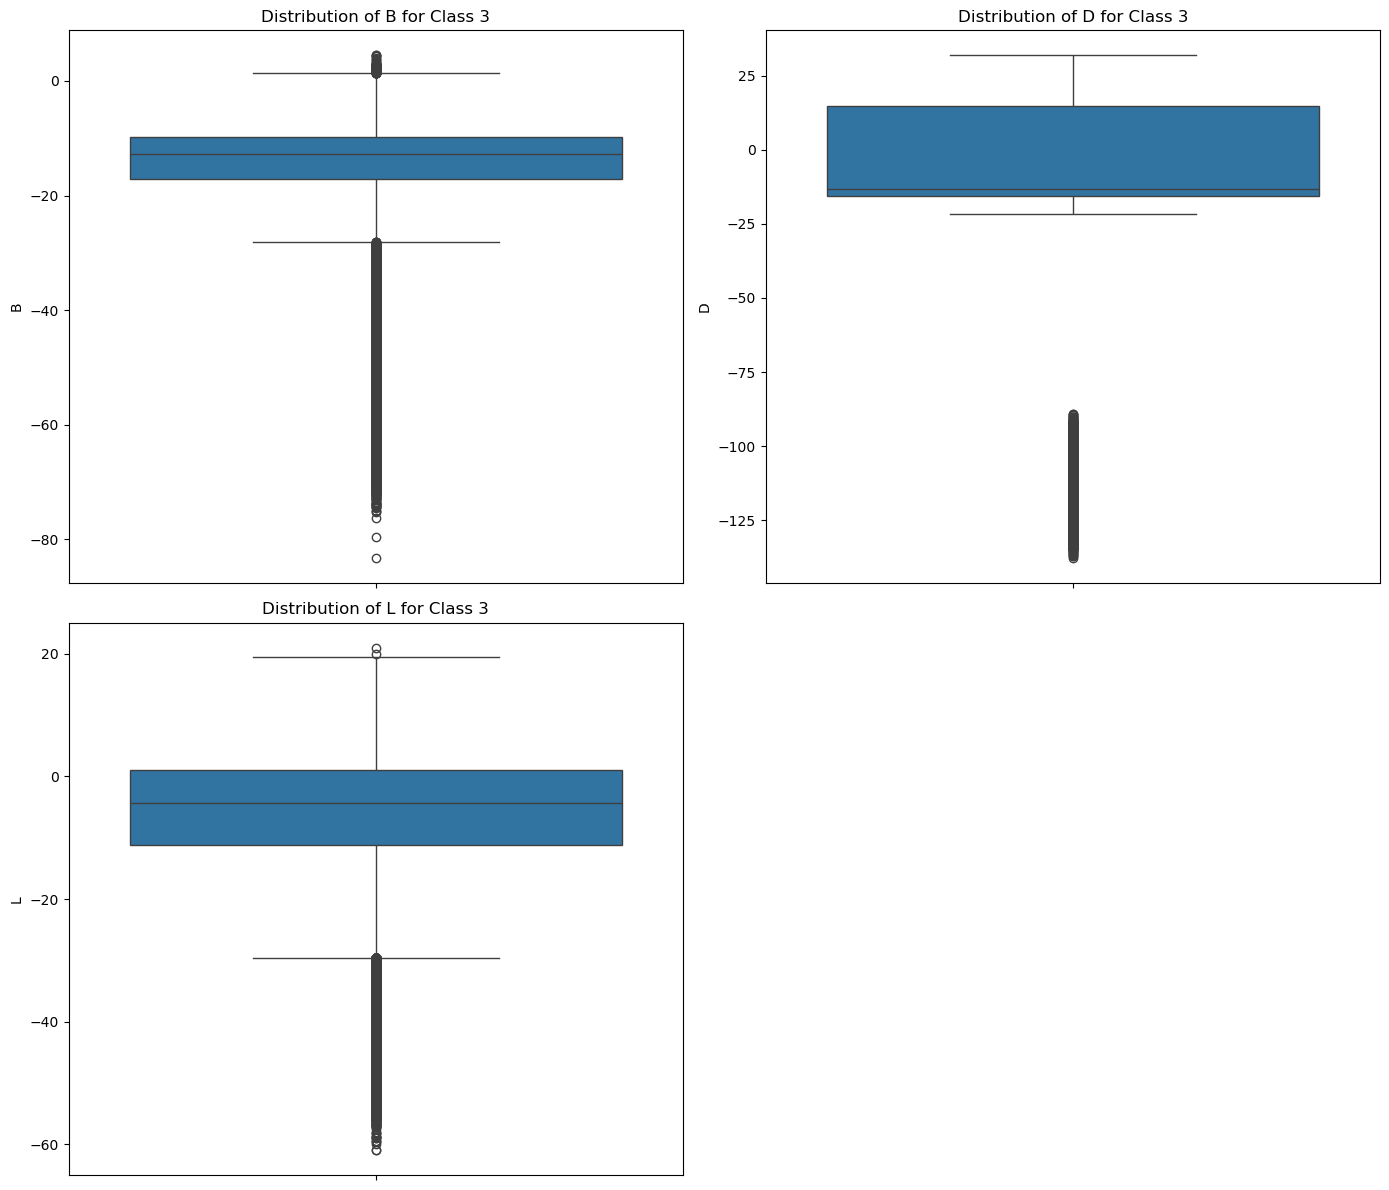

In [22]:
# Filter the dataset for Class 3
class_3_data = df[df['Class'] == 3]

# Select only the columns 'B', 'D', 'L'
class_3_data = class_3_data[['B', 'D', 'L']]

# Number of features to plot (excluding 'Class')
num_features = len(class_3_data.columns)

# Calculate number of columns and rows for subplots
ncols = 2  # Number of columns you want
nrows = int(np.ceil(num_features / ncols))  # Calculate rows based on the number of features

# Create subplots with the calculated number of rows and columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a subplot
for i, feature in enumerate(class_3_data.columns):
    sns.boxplot(y=class_3_data[feature], ax=axes[i])
    axes[i].set_title(f"Distribution of {feature} for Class 3")

# Remove any extra empty subplots if there are more subplots than features
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


### Observation:

The majority of outliers are present only on one side of the boundary (e.g., below the lower boundary), the issue might arise due to an asymmetric data distribution. 

So we are going to deal with the outliers differently for each feature in this case.

### Column D:

In [6]:
# List of columns to process
columns_to_process = ['D']  

# Filter out Class 3 data once
class_3_data = df[df['Class'] == 3]

# Loop through each column and handle outliers
for col in columns_to_process:
    # Calculate the IQR bounds for class 3 in the current column
    Q1 = class_3_data[col].quantile(0.25)
    Q3 = class_3_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = (class_3_data[col] < lower_bound) | (class_3_data[col] > upper_bound)

    # Replace outliers with NaN for class 3 in the current column
    df.loc[outliers & (df['Class'] == 3), col] = np.nan

We need to address left-skewed features (B and L) effectively while preserving the underlying patterns.

We are going to use different muliplier values in this case, as we don't misclassify legitimate data points as outliers in skewed distributions. 

### Columns B and L:

In [ ]:
# List of columns to process
columns_to_process = ['B', 'L']  

# Filter out Class 3 data once
class_3_data = df[df['Class'] == 3]

# Loop through each column and handle outliers
for col in columns_to_process:
    # Calculate the IQR bounds for class 3 in the current column
    Q1 = class_3_data[col].quantile(0.25)
    Q3 = class_3_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = (class_3_data[col] < lower_bound) | (class_3_data[col] > upper_bound)

    # Replace outliers with NaN for class 3 in the current column
    df.loc[outliers & (df['Class'] == 3), col] = np.nan

Let's again check for outliers.

In [ ]:
classes = df['Class']
features = df.drop('Class', axis=1)

# Function to calculate IQR and bounds for each feature, separately by class
def calculate_iqr_for_class(class_data):
    Q1 = class_data.quantile(0.25)
    Q3 = class_data.quantile(0.75)
    IQR = Q3 - Q1
    upper_bounds = Q3 + 1.5 * IQR
    lower_bounds = Q1 - 1.5 * IQR
    return lower_bounds, upper_bounds

# Function to calculate outliers for each class and feature
def count_outliers_by_class(class_label, feature_name, lower_bounds, upper_bounds):
    class_data = df[df['Class'] == class_label][feature_name]
    outliers = (class_data > upper_bounds[feature_name]) | (class_data < lower_bounds[feature_name])
    return outliers.sum()

# Function to calculate rows with at least one outlier for each class
def count_rows_with_at_least_one_outlier(class_label, lower_bounds, upper_bounds):
    class_data = df[df['Class'] == class_label][features.columns]
    outliers = (class_data > upper_bounds) | (class_data < lower_bounds)
    rows_with_outliers = outliers.any(axis=1).sum()  # Count rows with at least one outlier
    return rows_with_outliers

# Function to identify outliers for each feature based on class-specific bounds
def identify_outliers_by_class(class_label, lower_bounds, upper_bounds):
    class_data = df[df['Class'] == class_label][features.columns]
    outliers = (class_data > upper_bounds) | (class_data < lower_bounds)
    return outliers

# Function to calculate rows with at least one outlier across the entire dataset
def count_total_rows_with_at_least_one_outlier():
    # Initialize a DataFrame to track outliers across all classes
    outlier_mask = pd.DataFrame(False, index=df.index, columns=features.columns)
    
    # Iterate over each class and check for outliers
    for class_label in df['Class'].unique():
        lower_bounds, upper_bounds = calculate_iqr_for_class(df[df['Class'] == class_label][features.columns])
        outliers = identify_outliers_by_class(class_label, lower_bounds, upper_bounds)
        outlier_mask = outlier_mask | outliers  # Combine outliers across all classes
    
    # Count rows with at least one outlier (True) in any feature
    rows_with_outliers = outlier_mask.any(axis=1).sum()
    return rows_with_outliers

# Dictionary to store the result
outliers_by_class_feature = {}
rows_with_at_least_one_outlier = {}
total_outliers_per_class = {}

# Iterate through each class and feature to calculate outliers and rows with outliers
for class_label in df['Class'].unique():
    # Calculate IQR bounds for the current class
    lower_bounds, upper_bounds = calculate_iqr_for_class(df[df['Class'] == class_label][features.columns])

    # Initialize the dictionary for current class outliers
    outliers_by_class_feature[class_label] = {}

    # Calculate outliers by feature for the current class
    for feature_name in features.columns:
        count = count_outliers_by_class(class_label, feature_name, lower_bounds, upper_bounds)
        outliers_by_class_feature[class_label][feature_name] = count
    
    # Count rows with at least one outlier for the current class
    rows_with_at_least_one_outlier[class_label] = count_rows_with_at_least_one_outlier(class_label, lower_bounds, upper_bounds)
    
    # Calculate total number of outliers for the current class
    total_outliers = sum(outliers_by_class_feature[class_label].values())
    total_outliers_per_class[class_label] = total_outliers

# Convert the result to DataFrame for readability
outliers_df = pd.DataFrame(outliers_by_class_feature).T
rows_with_outliers_df = pd.DataFrame.from_dict(rows_with_at_least_one_outlier, orient='index', columns=['Rows with At Least One Outlier'])
total_outliers_df = pd.DataFrame.from_dict(total_outliers_per_class, orient='index', columns=['Total Outliers'])

# Merge all results into a single DataFrame
final_df = outliers_df.join([rows_with_outliers_df, total_outliers_df])

# Reorder the classes and transpose the DataFrame
final_df = final_df.sort_index().T

# Print the final result for outliers by class and feature
print("Outliers by Class and Feature:")
print(final_df)

# Calculate and print the total number of rows with at least one outlier across the entire dataset
total_rows_with_outliers = count_total_rows_with_at_least_one_outlier()
print(f"\nTotal rows with at least one outlier across the dataset: {total_rows_with_outliers}")

Outliers by Class and Feature:
                                1  2      3
B                               0  0   3705
D                               0  0      0
F                               0  0      0
I                               0  0      0
J                               0  0      0
L                               0  0  26062
M                               0  0      0
Rows with At Least One Outlier  0  0  29674
Total Outliers                  0  0  29767

Total rows with at least one outlier across the dataset: 29674


### Observation:
Due to skewed distribution there are still some outliers present but the total number is reduced significantly. 

## Save the processed datset:

In [9]:
import os

# Specify the directory path
dir_path = r"E:\IIT Chicago\Sem 3\Data Preparation and Analysis - CSP 571\Project\Final Submission"

# Create directory if it doesn't exist
os.makedirs(dir_path, exist_ok=True)

# Save your DataFrame
file_path = os.path.join(dir_path, 'processed_data.csv')
df.to_csv(file_path, index=False)